#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계1 : 데이터 탐색 및 전처리

## 0.미션

* 1) 데이터 탐색
    * intent 별 질문 개수 분포 확인하기
    * 질문 별 문장길이의 분포 확인하기
    * 대화 유형(type) 별 문장길이 분포 비교하기
    * 그 외 필요하다고 판단되는 부분에 대해 데이터를 탐색하고 분석하기
* 2) 전처리
    * 기본 전처리 : 데이터를 불러온 후 다음의 전처리를 먼저 수행합니다.
        * 한글 칼럼이름을 영문이름으로 변경하기
        * 두 데이터셋을 하나로 통합하기
        * intent 번호를 통합된 번호로 만들기
        * 일상대화와 Q&A 대화를 구분하는 구분자 칼럼 추가하기
    * 학습을 위한 전처리 : 자연어 처리를 위한 전처리를 수행합니다.
        * 형태소 분석기를 활용하여 문장 어절들에 대해 형태소로 변환합니다.
    * 전처리 결과를 저장합니다.

## 1.환경준비

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.
    - 구글드라이브 를 통해 데이터를 로딩합니다.

### (1) 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

### (2) 데이터 로딩
* 주어진 데이터셋
    * 학습 데이터 : 챗봇 데이터.xls
    * 학습 데이터 : 일상대화.xls
    * 엑셀 파일이므로 pd.read_excel 함수를 이용해서 불러 옵니다.
* Colab 환경에서 프로젝트 진행을 권장합니다.
    * 구글 드라이브에 project 폴더를 만들고 데이터 파일을 복사해 넣습니다.

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = ''

### (3) 데이터 읽어오기

In [4]:
# 일상대화
common_df = pd.read_excel('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project6_1/데이터/일상대화.xlsx')

# 에이블스쿨 질문답변
faq_df = pd.read_excel('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project6_1/데이터/챗봇데이터.xlsx')


* 데이터 둘러보기

In [5]:
common_df.head()

,intent,질문,답변
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.


In [7]:
common_df['intent'].value_counts()

8     68
3     39
20    34
30    30
28    28
13    24
21    24
29    18
2     16
1     16
27    15
26    13
23    11
11    10
12    10
4     10
5     10
25    10
24    10
22    10
6     10
7     10
19    10
18    10
17    10
9     10
15    10
14    10
10    10
16    10
Name: intent, dtype: int64

In [6]:
faq_df.head()

,intent,Q,A
0,0,어떤 조건을 만족하면 지원할 수 있는지 알고 싶어요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
1,0,지원자격이 어떻게 되나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
2,0,지원 조건이 궁금해요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
3,0,지원 자격에 대해서 알려주세요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
4,0,지원 자격 기준이 있나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...


## 2.데이터 탐색하기


* **세부 요구사항**
    * 데이터에 대한 기본 전처리를 수행합니다.
        * (필요시)한글 칼럼명을 영문명으로 변경,
        * 두 데이터셋 하나로 통합
        * 일상대화와 지원Q&A를 구분할 대화유형(type)칼럼 생성
    * 데이터 탐색하기
        * intent별 질문 수 확인
        * 각 질문별 문장길이에 대한 분포 확인
        * 대화유형(type)별 문장길이 분포 확인
        * 그외, 필요하다고 생각되는 탐색적 분석 수행

### (1) 데이터 기본 전처리

#### 1) column이름 통일하기(선택사항)
* 필수는 아니지만, 한글 칼럼명을 영문으로 변경합니다.

In [8]:
# common_df의 컬럼 이름을 변경합니다. '질문'을 'Q'로, '답변'을 'A'로 변경
common_df.rename(columns={'질문':'Q', '답변':'A'}, inplace=True)

#### 2) 데이터셋 통합
* intent 다시 번호 부여하기
    * 두 데이터의 intent 번호를 확인합니다.
    * 변경
        * common_df : 1 부터 시작되도록 하고
        * faq_df : common_df의 마지막 intent 이후부터 시작되도록 수정
* 두 데이터 셋을 통합합니다. (pd.concat)

* intent 번호 조정

In [9]:
common_df.sort_values('intent', ascending=True, inplace=True)

In [14]:
faq_df['intent'] = faq_df['intent'].apply(lambda x : x+31)
faq_df['intent'].value_counts()

32    138
50     60
39     60
46     60
45     40
40     40
41     40
43     40
31     39
52     20
51     20
49     20
48     20
47     20
53     20
44     20
38     20
35     20
34     20
33     20
36     19
37     18
42     18
Name: intent, dtype: int64

* 데이터셋 통합(pd.concat)

In [15]:
data = pd.concat([common_df, faq_df], axis=0)

In [17]:
data.tail()

,intent,Q,A
787,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
788,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
789,53,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
790,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
791,53,다른 교육보다 특별한 것이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...


#### 3) 일상대화와 Q&A대화 구분 칼럼(대화유형) 만들기
* 주어진 데이터셋은 두가지 종류입니다.
* 통합 데이터에 type 칼럼을 추가하고, 일상대화를 0, Q&A를 1로 지정하시오.

In [21]:
common_df.shape, faq_df.shape

((506, 3), (792, 3))

In [19]:
data['type'] = np.where(data['intent'].isin(list(range(1,31))),0,1)

In [20]:
data['type'].value_counts()

1    792
0    506
Name: type, dtype: int64

### (2) 데이터 탐색하기


* 세부 요구사항
    - intent별 질문 개수 분포를 확인합니다.
        * 문의 유형별 길이에 대한 기초통계량과  시각화(히스토그램, 박스플롯 등)를 통해 분포를 확인합니다.
    - 질문별 문장 길이 분포를 확인합니다.

#### 1) intent별 질문 개수 살펴보기
* intent 별 데이터 개수를 bar plot 등을 이용하여 시각화 합니다.

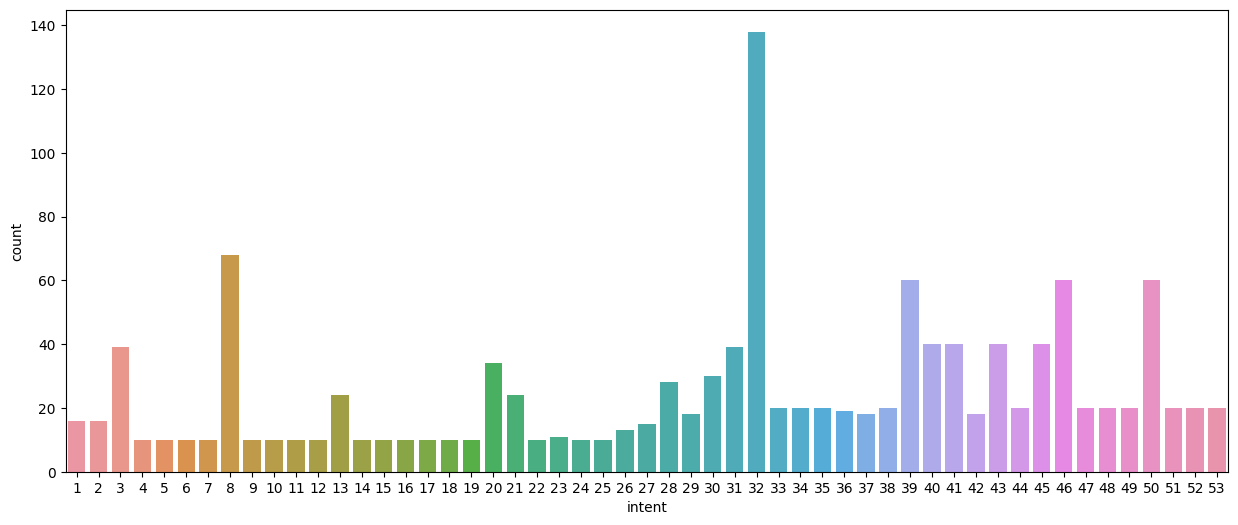

In [23]:
plt.figure(figsize=(15,6))
sns.countplot(x='intent', data=data)
plt.show()

#### 2) 질문별 문장 길이 분포
* 질문 별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

In [24]:
data['len'] = data['Q'].apply(len)

In [37]:
data.head()

,intent,Q,A,type,len
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0,16
15,1,노트북 안돼,AS센터에 맡겨보세요.,0,6
14,1,핸드폰 안돼,AS센터에 맡겨보세요.,0,6
13,1,핸드폰 맛이 갔어,AS센터에 맡겨보세요.,0,9
12,1,핸드폰 고장났나봐,AS센터에 맡겨보세요.,0,9


In [41]:
data.groupby('intent')['len'].describe()

,count,mean,std,min,25%,50%,75%,max
intent,,,,,,,,
1,16.0,11.750000,5.208967,6.0,7.50,10.5,16.00,21.0
2,16.0,11.312500,4.331570,6.0,7.75,11.0,14.25,21.0
3,39.0,9.153846,3.468190,3.0,7.00,9.0,11.00,19.0
4,10.0,11.200000,4.104198,6.0,8.25,11.5,13.00,20.0
5,10.0,9.600000,3.373096,3.0,7.75,10.0,11.75,14.0
6,10.0,13.200000,4.315347,8.0,10.00,12.5,15.50,20.0
7,10.0,13.200000,4.022161,10.0,11.00,12.0,13.75,24.0
8,68.0,10.544118,4.704503,3.0,7.75,10.0,12.25,23.0
9,10.0,8.000000,2.309401,6.0,7.00,7.0,8.50,14.0


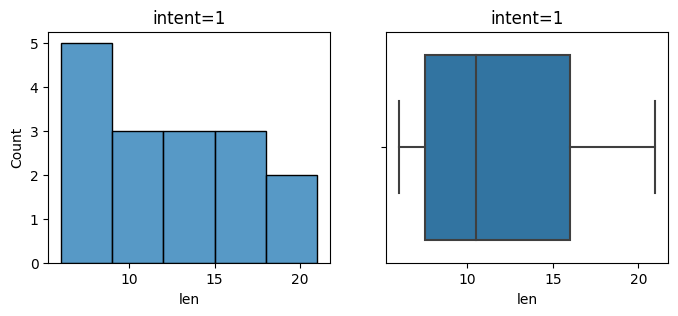

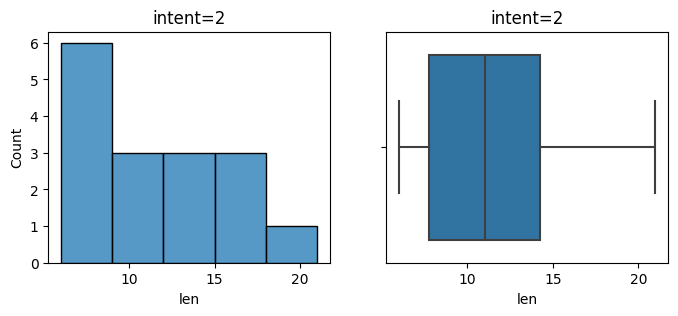

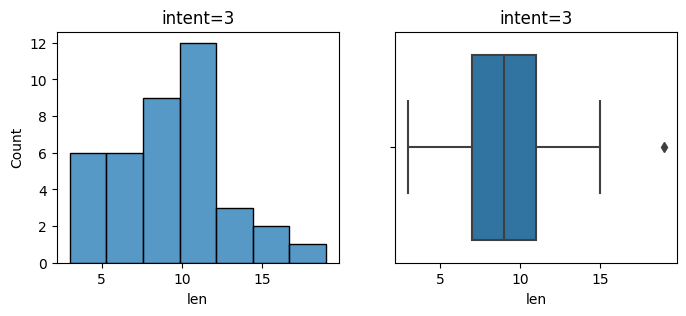

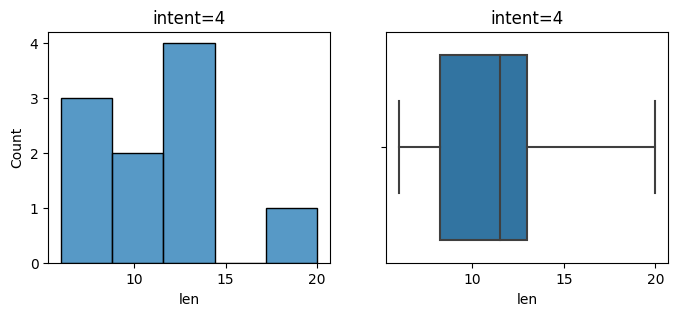

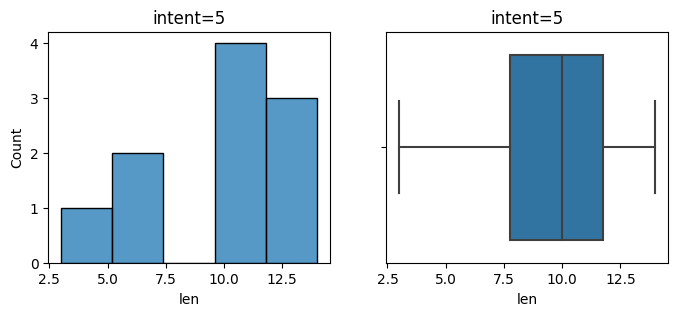

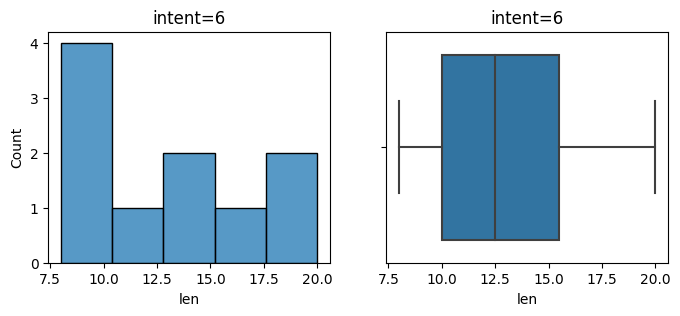

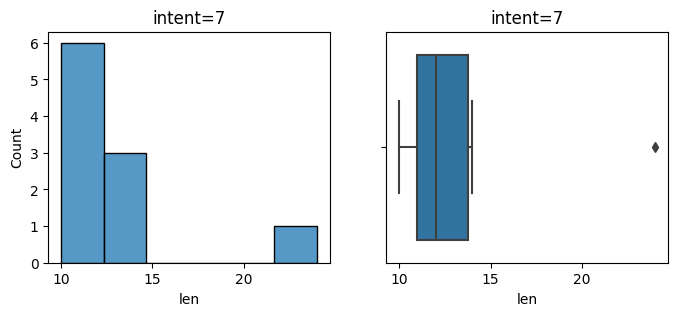

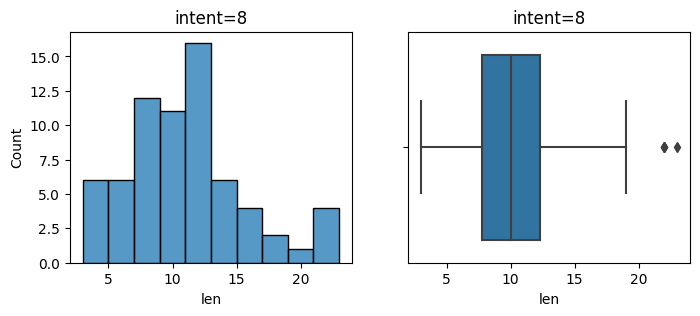

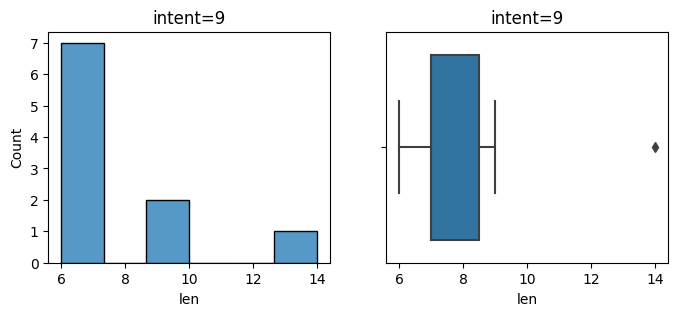

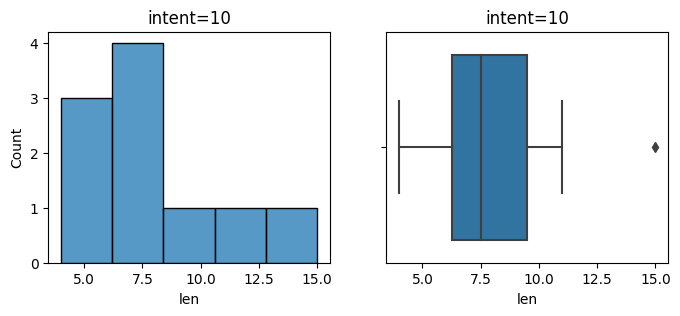

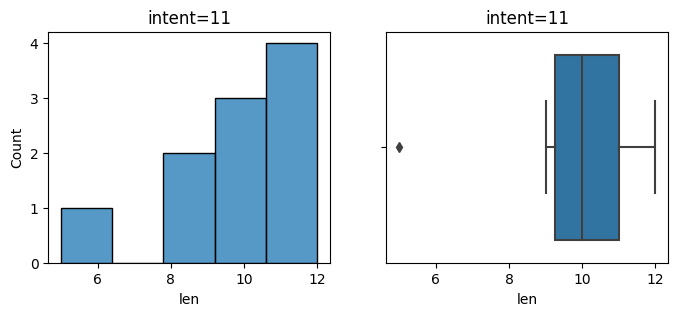

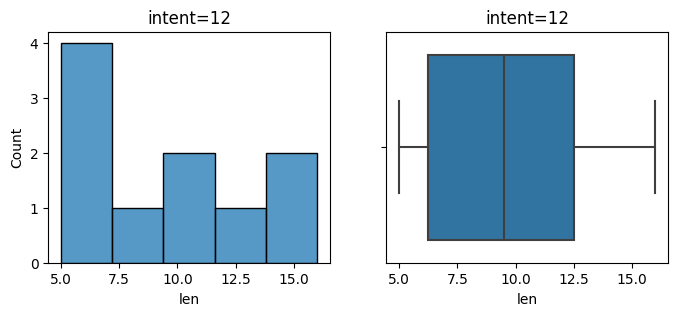

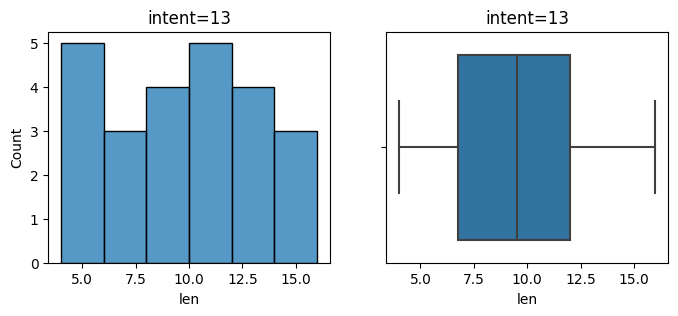

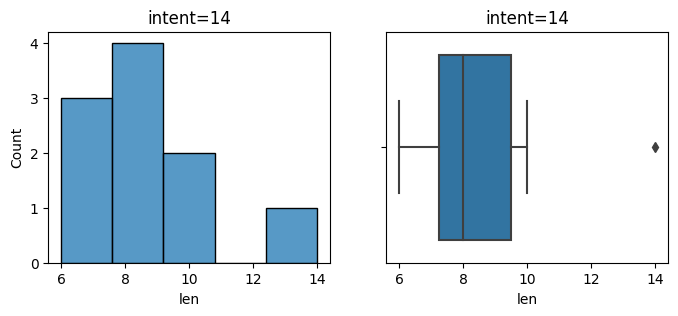

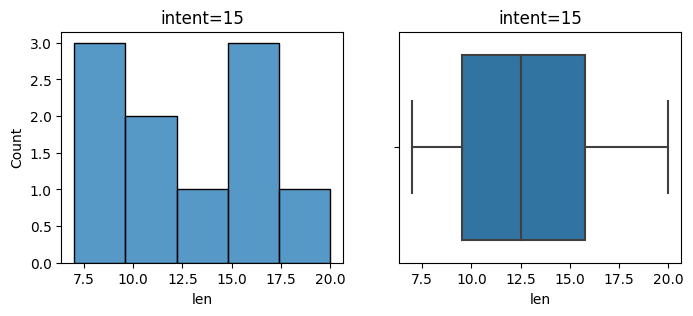

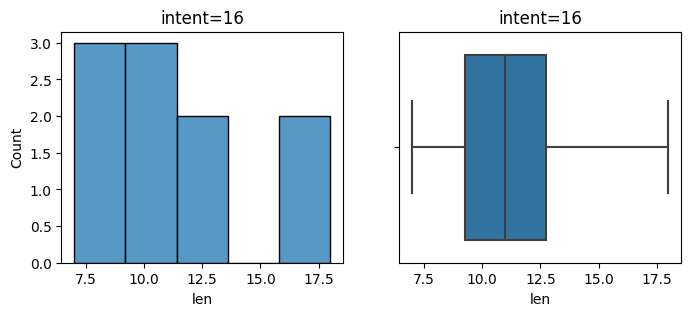

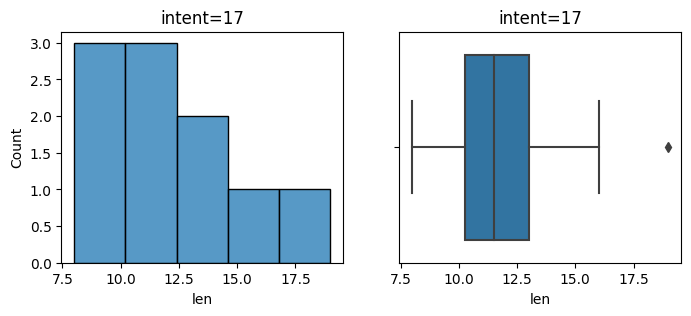

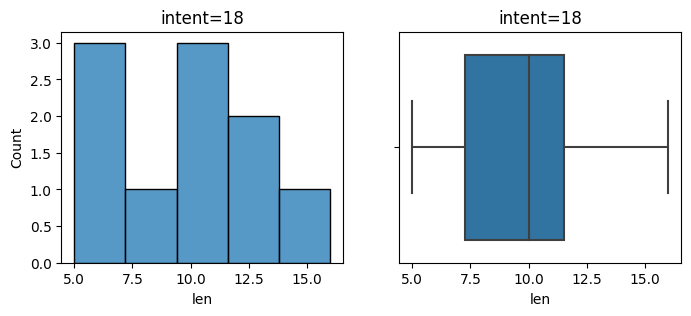

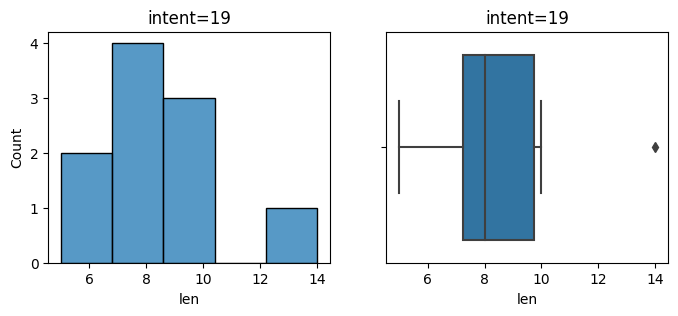

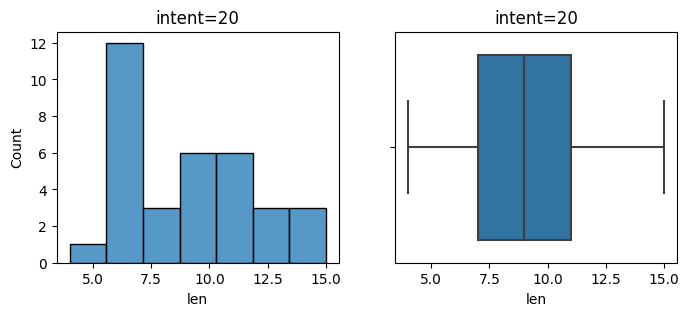

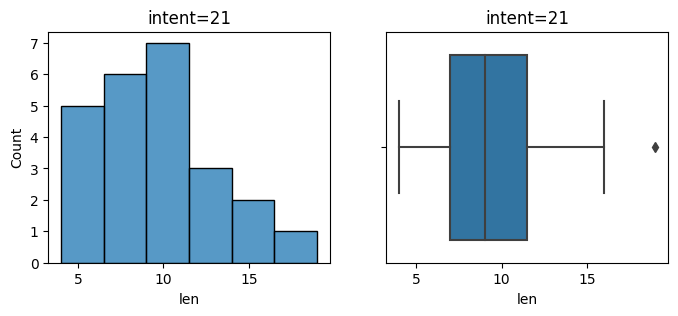

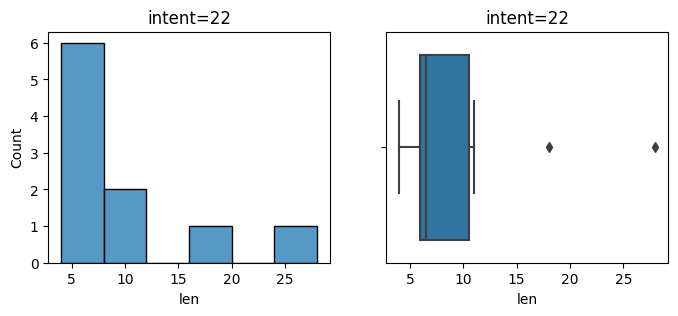

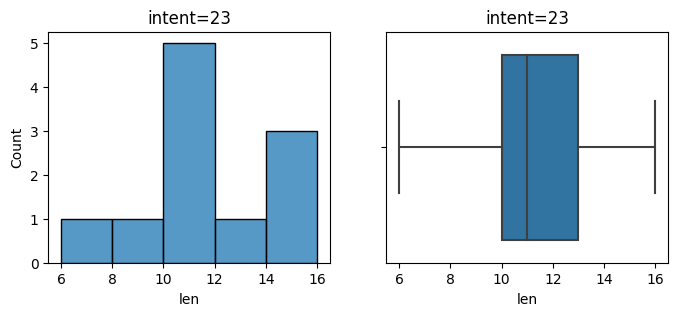

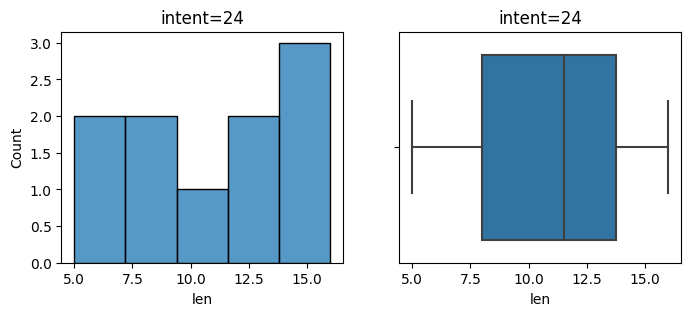

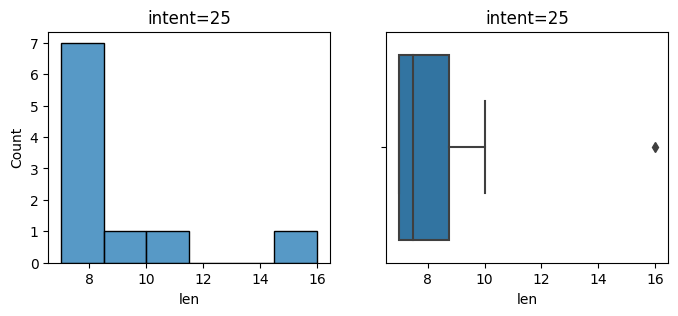

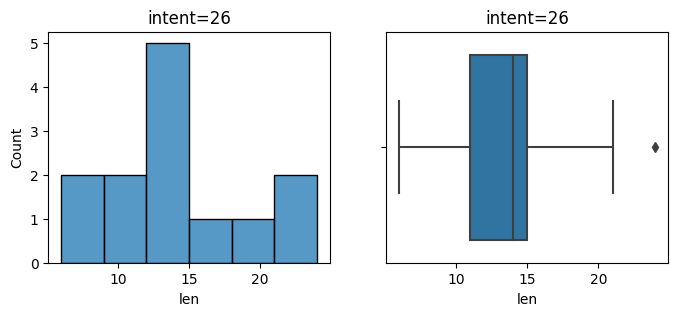

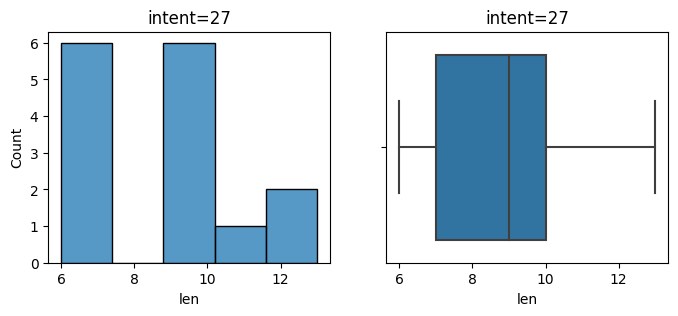

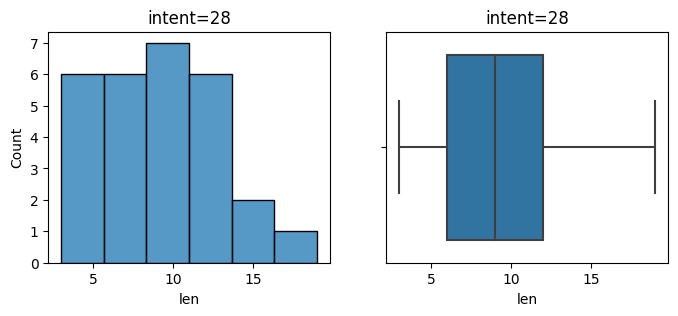

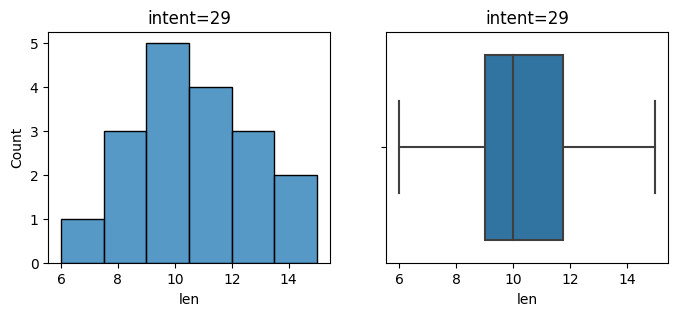

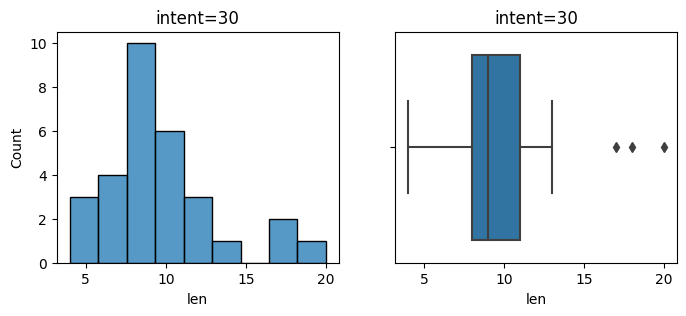

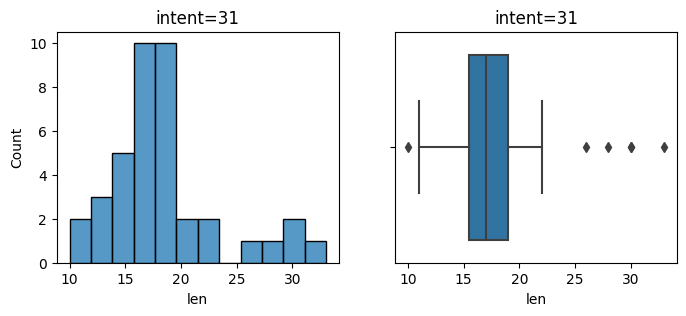

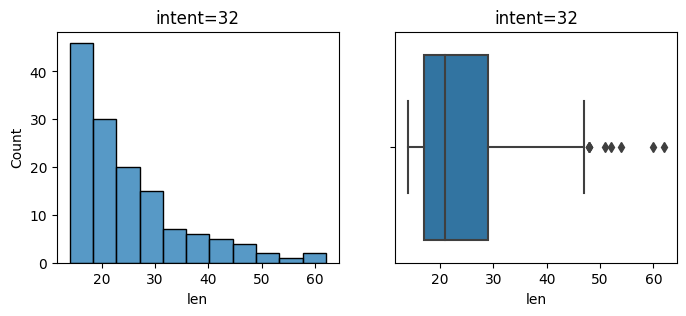

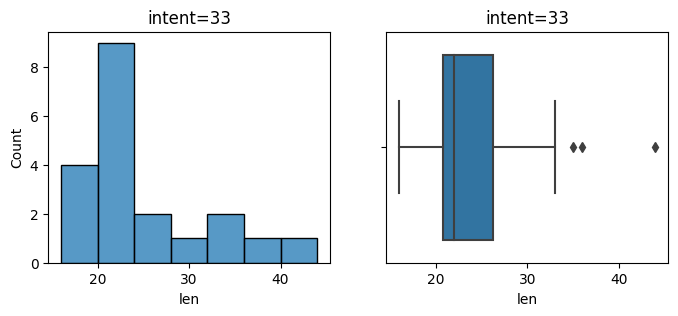

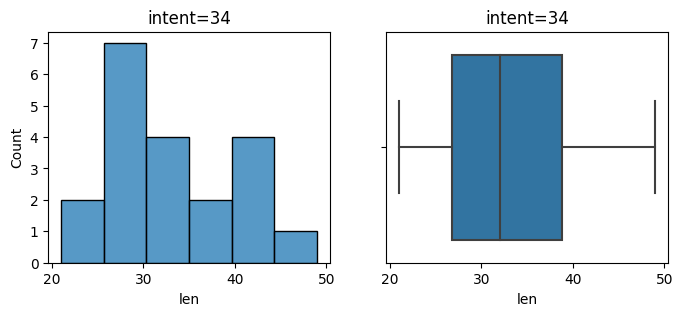

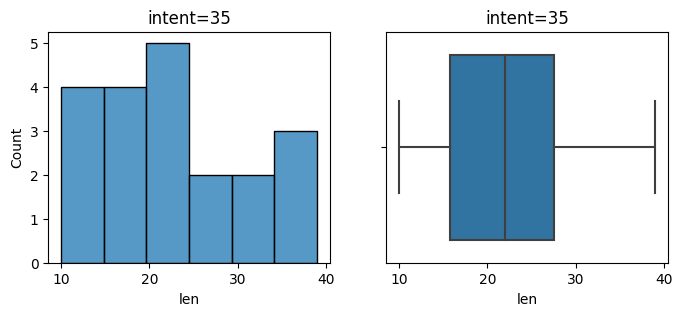

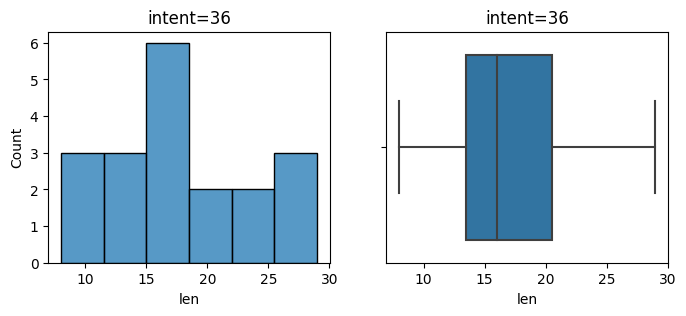

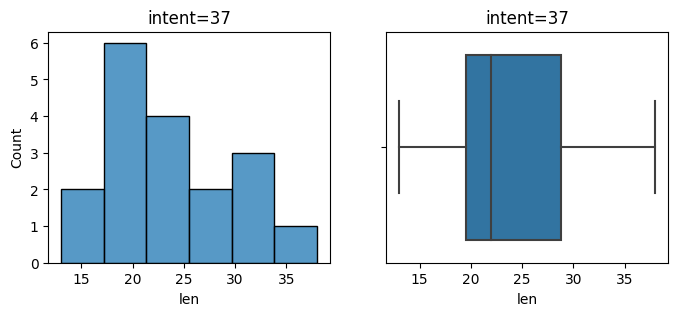

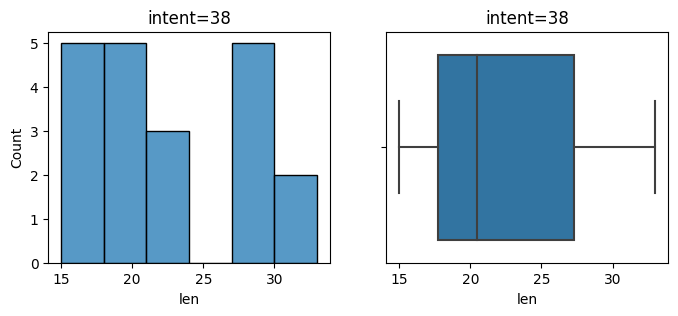

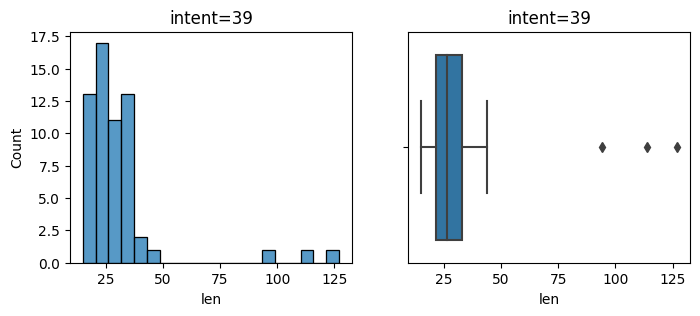

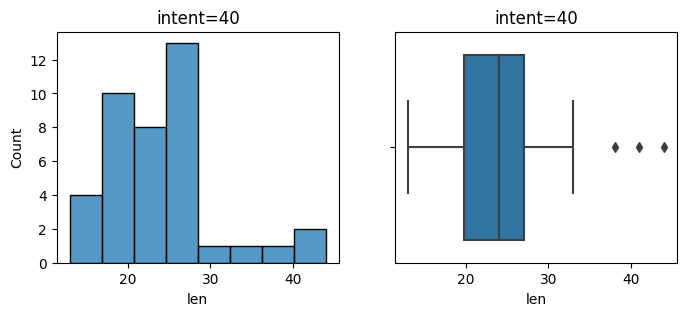

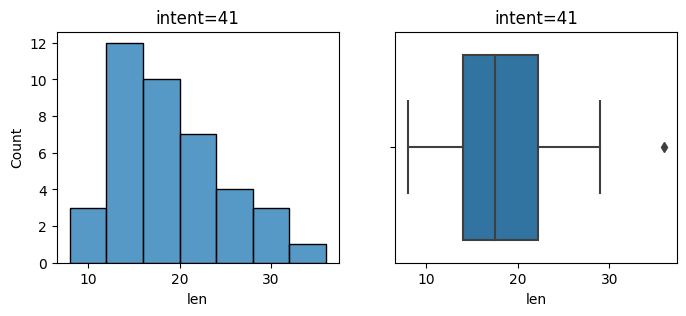

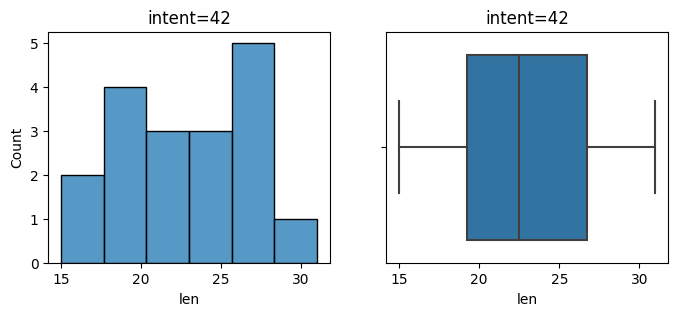

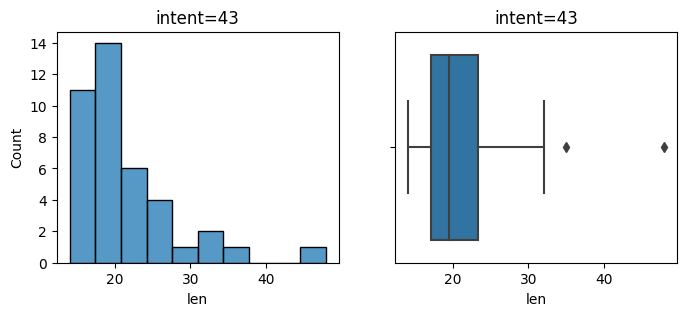

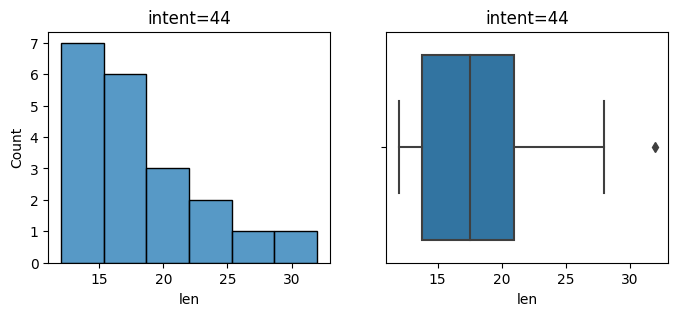

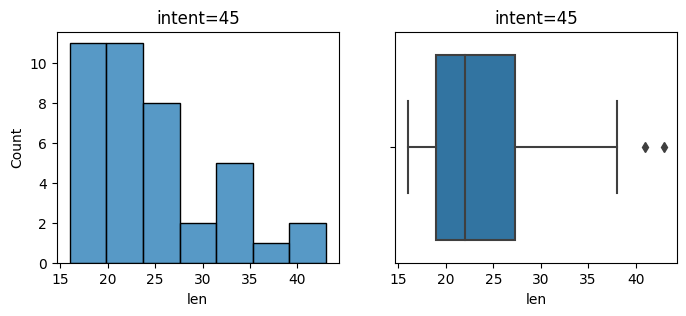

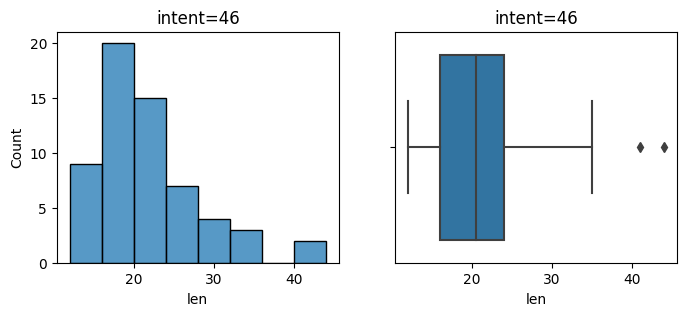

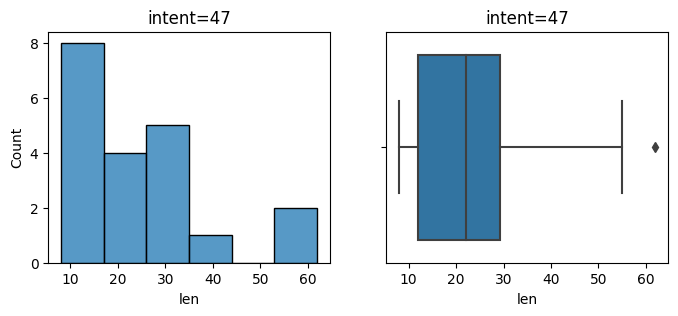

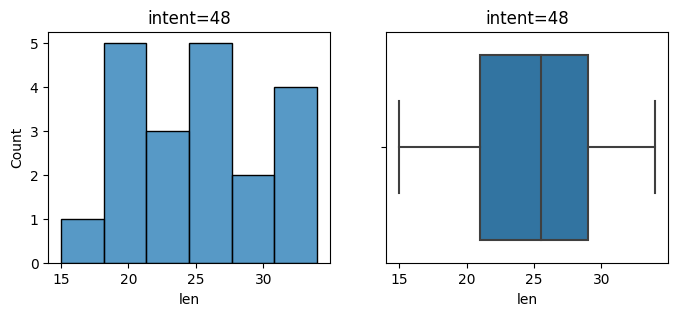

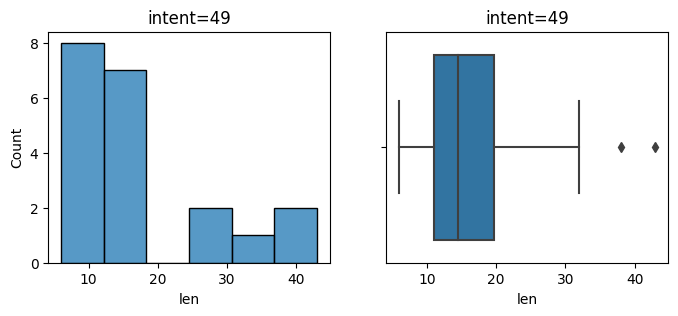

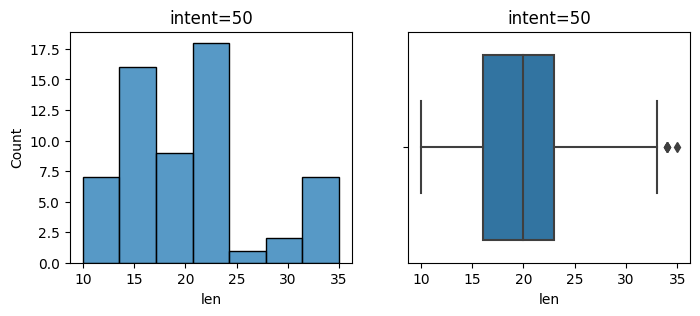

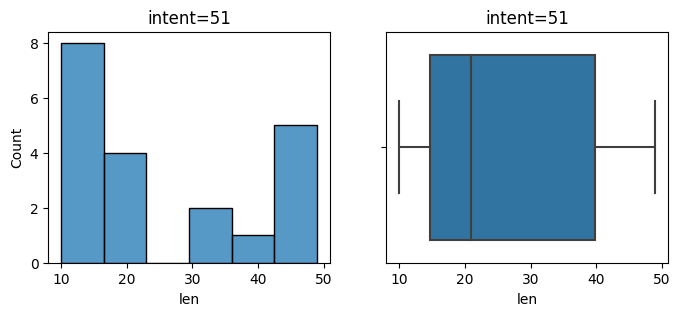

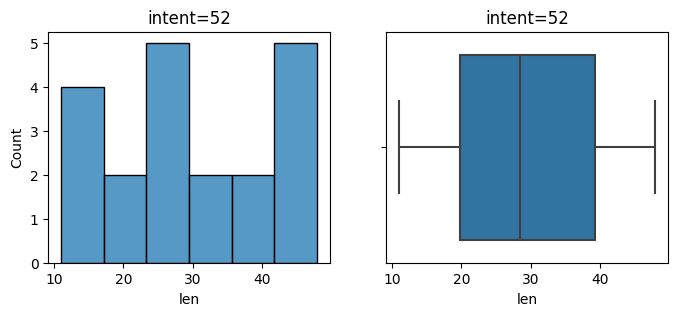

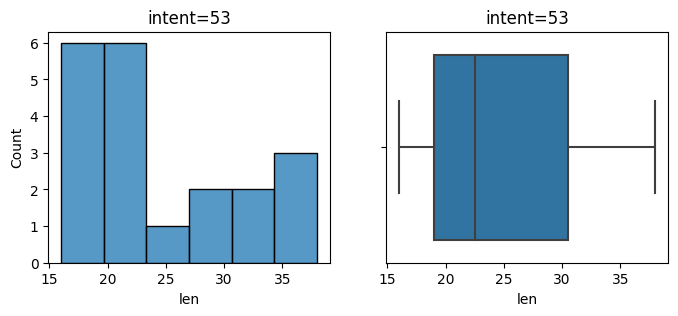

In [30]:
for i in range(1, 54):
    df = data.loc[data['intent']==i]
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    sns.histplot(x='len', data=df)
    plt.title(f'intent={i}')
    plt.subplot(1,2,2)
    sns.boxplot(x='len', data=df)
    plt.title(f'intent={i}')
    plt.show()

#### 3) 대화 유형(type) 별 문장 길이 분포 비교
* 타입별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

In [32]:
data.loc[data['type']==0]['len'].describe()

count    506.000000
mean      10.126482
std        3.971658
min        3.000000
25%        7.000000
50%       10.000000
75%       12.000000
max       28.000000
Name: len, dtype: float64

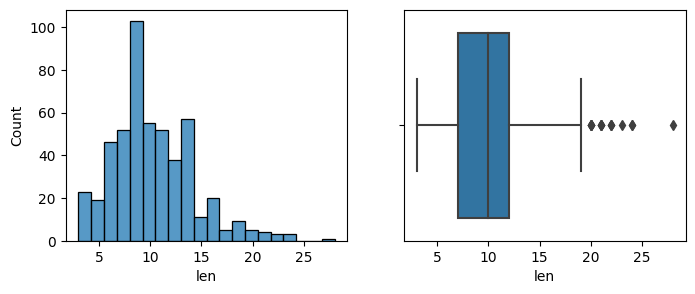

In [33]:
df = data.loc[data['type']==0]
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.histplot(x='len', data=df)
plt.subplot(1,2,2)
sns.boxplot(x='len', data=df)
plt.show()

In [34]:
data.loc[data['type']==1]['len'].describe()

count    792.000000
mean      23.434343
std       10.258270
min        6.000000
25%       17.000000
50%       21.000000
75%       28.000000
max      127.000000
Name: len, dtype: float64

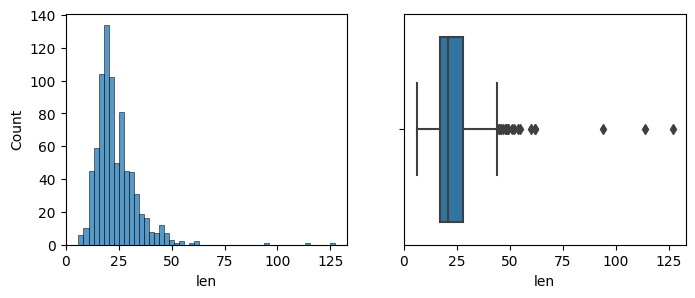

In [35]:
df = data.loc[data['type']==1]
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.histplot(x='len', data=df)
plt.subplot(1,2,2)
sns.boxplot(x='len', data=df)
plt.show()

## 3.데이터 전처리

* 세부요구사항
    * 다음 항목에 해당되는 전처리 함수를 각각 생성하여 하나로 합쳐봅시다.
        * 특수문자 제거 : 정규 표현식을 활용합니다. (띄어쓰기, \n 등)
        * 형태소 분석기 사용 : konlpy(mecab, kkma, Okt, etc), soynlp, khaiii 등 여러 형태소 분석기를 활용합니다.
    * 문장길이를 조절하여 모델 input으로 활용하기
    * joblib.dump를 이용하여 전처리 결과 데이터를 저장합니다.

### (1) 학습/평가 데이터 분리
   * test 데이터 : intent마다 무작위로 질문 2개를 뽑아 test 데이터로 분리
   * train 데이터 : 나머지 데이터


In [42]:
import re
import string
#removal_list =  "‘, ’, ◇, ‘, ”,  ’, ', ·, \“, ·, △, ●,  , ■, (, ), \", >>, `, /, -,∼,=,ㆍ<,>, .,?, !,【,】, …, ◆,%"
removal_list =  "‘’◇‘”’'·\“·△●■()\">>`/-∼=ㆍ<>.?!【】…◆%"
removal_list += string.punctuation
def cleansing_special(sentence: str = None) -> str:
    """
    특수문자를 전처리를 하는 함수
    :param sentence: 전처리 대상 문장
    :return: 전처리 완료된 문장
    """
    #sentence = re.sub("[.,\'\"’‘”“!?]", "", sentence)
    sentence = re.sub("[^가-힣0-9a-zA-Z\\s]", " ", sentence)
    sentence = re.sub("\s+", " ", sentence)

    sentence = sentence.translate(str.maketrans(removal_list, ' '*len(removal_list)))
    sentence = sentence.strip()
    return sentence

In [43]:
data['Q']=data['Q'].apply(cleansing_special)

In [ ]:
# 데이터를 섞습니다.
df = data.sample(frac=1, random_state=42).reset_index(drop=True)

# 테스트 데이터와 훈련 데이터를 저장할 데이터프레임 생성
test_data = pd.DataFrame(columns=list(df))
train_data = pd.DataFrame(columns=list(df))

# 각 인텐트당 2개의 질문을 테스트 데이터로 선택
intents = df['intent'].unique()
for intent in intents:
    intent_df = df[df['intent'] == intent]

    # 2개의 질문을 무작위로 선택
    test_samples = intent_df.sample(n=2, random_state=42)

    # 선택한 질문을 테스트 데이터로 추가
    test_data = test_data.append(test_samples)

# 나머지 데이터는 훈련 데이터로 추가
train_data = df[~df.index.isin(test_data.index)]

In [45]:
# 테스트 데이터와 훈련 데이터를 출력
print("Test Data:")
print(test_data.shape)

print("\nTrain Data:")
print(train_data.shape)

Test Data:
(106, 5)

Train Data:
(1192, 5)


### (2) 형태소 분석하기
- konlpy, mecab 설치 후 형태소 분석 함수 생성
    * Colab에서는 아래 두 코드셀을 순차적으로 실행하면 설치 됩니다.
        * 참조 : https://konlpy.org/en/latest/install/
- 형태소 분석 결과를 다음의 이름으로 생성하시오.
    - clean_train_questions
    - clean_test_questions

#### 1) 형태소 분석 패키지 설치

In [ ]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

In [ ]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

#### 2) 형태소 분석을 위한 함수를 제공합니다.

In [49]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()

    return tokenizer

In [50]:
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)

    return tokenized_sent

#### 3) 형태소 분석 테스트
* 몇개 데이터에 대해 형태소 분석 확인하기

In [63]:
tokenize('mecab',df['Q'][0])

'교육 지역 변경 이 가능 한 경우 가 있 나요'

In [64]:
tokenize('mecab',df['Q'][500])

'패드 로 도 수강 할 수 있 나요'

In [65]:
tokenize('mecab',df['Q'][1000])

'제공 되 는 노트북 성능 이 어떻게 되 나요'

#### 4) train, test의 Q에 대해 형태소 분석하여 저장하기
* 데이터프레임의 각 행 별로 함수를 적용하는 방법
    * .apply(lambda ..........) 를 활용하면 손쉽게 처리할수 있습니다.

In [66]:
clean_train_questions = train_data['Q'].apply(lambda x : tokenize('mecab',x))
clean_test_questions = test_data['Q'].apply(lambda x : tokenize('mecab',x))

### (3) 전처리 완료된 데이터를 파일로 저장하기
- 총 4개의 파일을 저장합니다.
    * train 셋
    * test 셋
    * 전처리된 데이터
        * clean_train_questions
        * clean_test_questions
- 저장방법
    * joblib 라이브러리를 이용하여 저장합니다.

In [70]:
# 'train_data.pkl'
joblib.dump(train_data, '/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project6_1/데이터/train_data.pkl')
# test
joblib.dump(test_data, '/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project6_1/데이터/test_data.pkl')
# clean_train
joblib.dump(clean_train_questions, '/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project6_1/데이터/clean_train_questions.pkl')
# clean_test
joblib.dump(clean_test_questions, '/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project6_1/데이터/clean_test_questions.pkl')

['/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project6_1/데이터/clean_test_questions.pkl']

In [71]:
c_te = joblib.load('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project6_1/데이터/train_data.pkl')
c_te.head()

,intent,Q,A,type,len
0,43,교육 지역 변경이 가능한 경우가 있나요,"KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...",1,22
1,32,재직 중에도 수강 가능한가요,"KT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시작일 기준 재직자는 지원이 불가...",1,16
4,32,고용보험 미가입자는 미취업자로 보나요,"KT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시작일 기준 재직자는 지원이 불가...",1,21
5,32,프리랜서도 근로자로 보나요,"KT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시작일 기준 재직자는 지원이 불가...",1,15
6,40,사전에 공부하면 좋은 과목을 추천해주세요,비전공자도 SW개발에 관심과 열정이 있으신 분들은 충분히 따라 갈 수 있습니다. ...,1,23


In [72]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1192 entries, 0 to 1297
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   intent  1192 non-null   int64 
 1   Q       1192 non-null   object
 2   A       1192 non-null   object
 3   type    1192 non-null   int64 
 4   len     1192 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 55.9+ KB
